<a href="https://colab.research.google.com/github/i-malur/meteora-analise-de-dados-sql/blob/main/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
engine = create_engine('sqlite:///:memory:')

In [5]:
produtos.to_sql('produtos',engine,index=False)

205

In [6]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [7]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [8]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [9]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()

pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [10]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [16]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


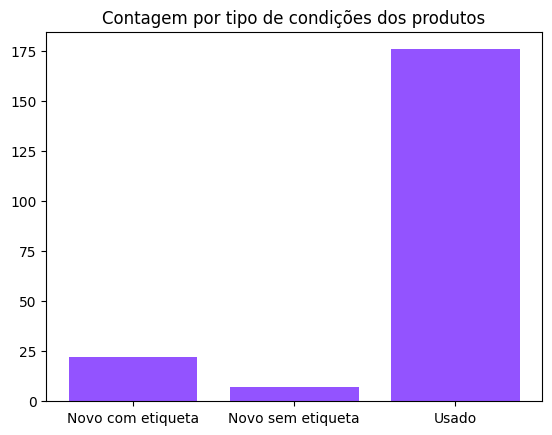

In [18]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [19]:
sql_df ('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [20]:
sql_df ('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [21]:
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY ITENS_PEDIDOS.PRODUTO_ID;
'''
sql_df(query)


,produto_id,produto,SUM(ITENS_PEDIDOS.QUANTIDADE)
0,2706,Blusa Cinza,341
1,3451,Vestido Ombro So,431
2,3820,Shorts Jeans Tye Dye,453
3,3829,Sneaker Monograma Bege,418
4,3865,Bolsa Classica Roxa,440
...,...,...,...
200,100484,Calca Jeans Pantacourt,397
201,100932,Sapato Cetim Pink,467
202,100939,Blusa Suede Caramelo,421
203,100961,Vestido Preto Renda,388


# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

# Projeto com pandas

* Possíveis soluções para problemas apresentados

Construímos um código de consulta a um banco de dados com SQL, mas e se ao invés de quatro tabelas em um SGBD, nós estivéssemos lidando com DataFrames?

Digamos que os DataFrames tenham os mesmos nomes de cada uma das tabelas, vamos então ver como seria o código em Pandas que corresponderia ao resultado obtido pelas consultas que fizemos em aula no SQL.

Passo a passo
1. SELECT CONDICAO FROM PRODUTOS  
Precisamos obter o mesmo resultado da consulta, ou seja, um DataFrame. Para tal, podemos selecionar a coluna Condicao e executar a transformação da Series para DataFrame com pd.DataFrame.
2. pd.DataFrame(produtos['Condicao'])
3. SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;  
Para aplicar uma função de agregação por contagem de frequências, podemos aplicar groupby e a agregação de contagem com size. O nome da coluna de 'Quantidade' pode ser definido com reset_index.
4.produtos.groupby('Condicao').size().reset_index(name='Quantidade')

# Documentação


### SQL o que é?

SQL (Structured Query Language) é uma linguagem de programação projetada para gerenciar e manipular bancos de dados relacionais. Ela fornece um conjunto de comandos e instruções que permitem a criação, consulta, atualização e exclusão de dados em bancos de dados.

O uso dessa linguagem é essencial para trabalhar com dados armazenados em bancos de dados relacionais e é uma habilidade fundamental para pessoas desenvolvedoras, analistas de dados, administradoras de bancos de dados e outras categorias de profissões envolvidas na manipulação e análise de dados.

A linguagem SQL também é bastante utilizada em Sistemas de Gerenciamento de Bancos de Dados relacionais (SGBDs), como MySQL, PostgreSQL, SQLite, Oracle, SQL Server, entre outros. Ela oferece uma sintaxe padrão e consistente, tornando-se uma linguagem altamente portátil e interoperável entre diferentes sistemas de banco de dados.

O SQL possui comandos básicos que são fundamentais para a manipulação de dados em um banco de dados relacional, dois deles são o SELECT e o FROM.

O SELECT é usado para exibir dados de uma ou mais tabelas em um banco de dados. Ele permite especificar as colunas que você deseja selecionar.  
O FROM é usado em conjunto com o SELECT para especificar a tabela ou tabelas das quais você deseja recuperar os dados. Ele indica a origem dos dados que serão selecionados.

*  https://www.alura.com.br/artigos/o-que-e-sql
*  https://www.alura.com.br/artigos/sgbds-relacionais
*  https://www.alura.com.br/artigos/sql-comandos-basicos
*  https://www.alura.com.br/artigos/sql-consultas-com-select
*  https://www.alura.com.br/artigos/sql-clausulas-update-e-delete
